This notebooks provides a template for pre-processing and inverting ICESat-2 (ATL15) data around Greenland subglacial lakes.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os 
from scipy.interpolate import griddata
import rasterio as rio
from shapely.geometry import Polygon
import geopandas as gpd

sys.path.insert(0, '../source')
sys.path.insert(0, '../scripts')


In [2]:
import metavars
metavars.lake_name = 'north'
lake_name = metavars.lake_name

data_name = 'data_'+lake_name
if os.path.isdir('../'+data_name)==False:
    os.mkdir('../'+data_name)

In [3]:
# define paths to ICESat-2 data and other data sets
paths = {}
paths['icesat'] = '../../ICESat-2/ATL15/ATL15_GL_0318_01km_003_01.nc'
paths['bedmachine'] = '../../bedmachine/BedMachineGreenland-v5.nc'
paths['measures_x'] = '../../measures/greenland_vel_mosaic200_2017_2018_vx_v02.1.tif'
paths['measures_y'] = '../../measures/greenland_vel_mosaic200_2017_2018_vy_v02.1.tif'


In [4]:
# load ICESat-2 ATL15 data set
fn = paths['icesat']
ds = nc.Dataset(fn)
dsh = ds['delta_h']

dh = dsh['delta_h'][:]        # elevation change (m)
x = dsh['x'][:]               # x coordinate array (m)
y = dsh['y'][:]               # y coordinate array (m)
t = dsh['time'][:]            # t coordinate array (d)
mask = dsh['ice_area'][:]

dh -= dh[0,:,:] # subtract initial elevation profile

In [5]:
# Define a box for a regional-scale zoom-in
L00 = 100*1e3          # width/length of box
x00 = -160*1e3         # center x-coordinate
y00 = -1080*1e3        # center y-coordinate

x_min0 = x00-L00/2       
x_max0 = x00+L00/2
y_min0 = y00-L00/2
y_max0 = y00+L00/2

In [6]:
# define 'localize' function that removes mean elevaiton-change trend of surrounding area
def localize(f,x,y):
    f_far = np.copy(f)
    f_far[np.sqrt((x-x.mean())**2+(y-y.mean())**2)<0.75*np.sqrt((x-x.mean())**2+(y-y.mean())**2).max()] = 0
    F = (f_far != 0).sum(axis=(1,2))+1e-10
    f_far = f_far.sum(axis=(1,2))/F
    f_loc = f- np.multiply.outer(f_far,np.ones(np.shape(f[0,:,:])))
    return f_loc

In [7]:
# Define a box for zooming in further! 
L0 = 40*1e3          # width/length of box
x0 = x00             # center x-coordinate
y0 = y00-10*1e3      # center y-coordinate

# define coordinates for the edges of the box
x_min = x0-L0/2       
x_max = x0+L0/2
y_min = y0-L0/2
y_max = y0+L0/2


nt = np.size(t)

def get_zoomed(dh,x,y,x_min,x_max,y_min,y_max):

    ind_x = np.arange(0,np.size(x),1)
    ind_y = np.arange(0,np.size(y),1)

    # extract the data that is inside the bounding box
    x_sub = x[(x>=x_min)&(x<=x_max)]
    y_sub = y[(y>=y_min)&(y<=y_max)]
    inds_x = ind_x[(x>=x_min)&(x<=x_max)]
    inds_y = ind_y[(y>=y_min)&(y<=y_max)]

    nx = np.size(inds_x)
    ny = np.size(inds_y)

    inds_xy = np.ix_(inds_y,inds_x)
    dh_sub = np.zeros((nt,ny,nx))

    # put elevation change maps into 3D array with time being the first index
    for i in range(nt):
        dh0 = dh[i,:,:].filled()
        dh_sub[i,:,:] = dh0[inds_xy]

    t_s,y_s,x_s = np.meshgrid(t,y_sub,x_sub,indexing='ij')
    dh_loc = localize(dh_sub,x_s,y_s)

    off_lake = dh_sub-dh_loc
    off_lake = off_lake[:,0,0]
   
    return dh_sub,dh_loc,off_lake, x_sub,y_sub

dh_sub,dh_loc,off_lake, x_sub, y_sub = get_zoomed(dh,x,y,x_min,x_max,y_min,y_max)

dh_sub0,dh_loc0,off_lake0, x_sub0, y_sub0 = get_zoomed(dh,x,y,x_min0,x_max0,y_min0,y_max0)

X_sub,Y_sub = np.meshgrid(x_sub,y_sub)
X_sub0,Y_sub0 = np.meshgrid(x_sub0,y_sub0)

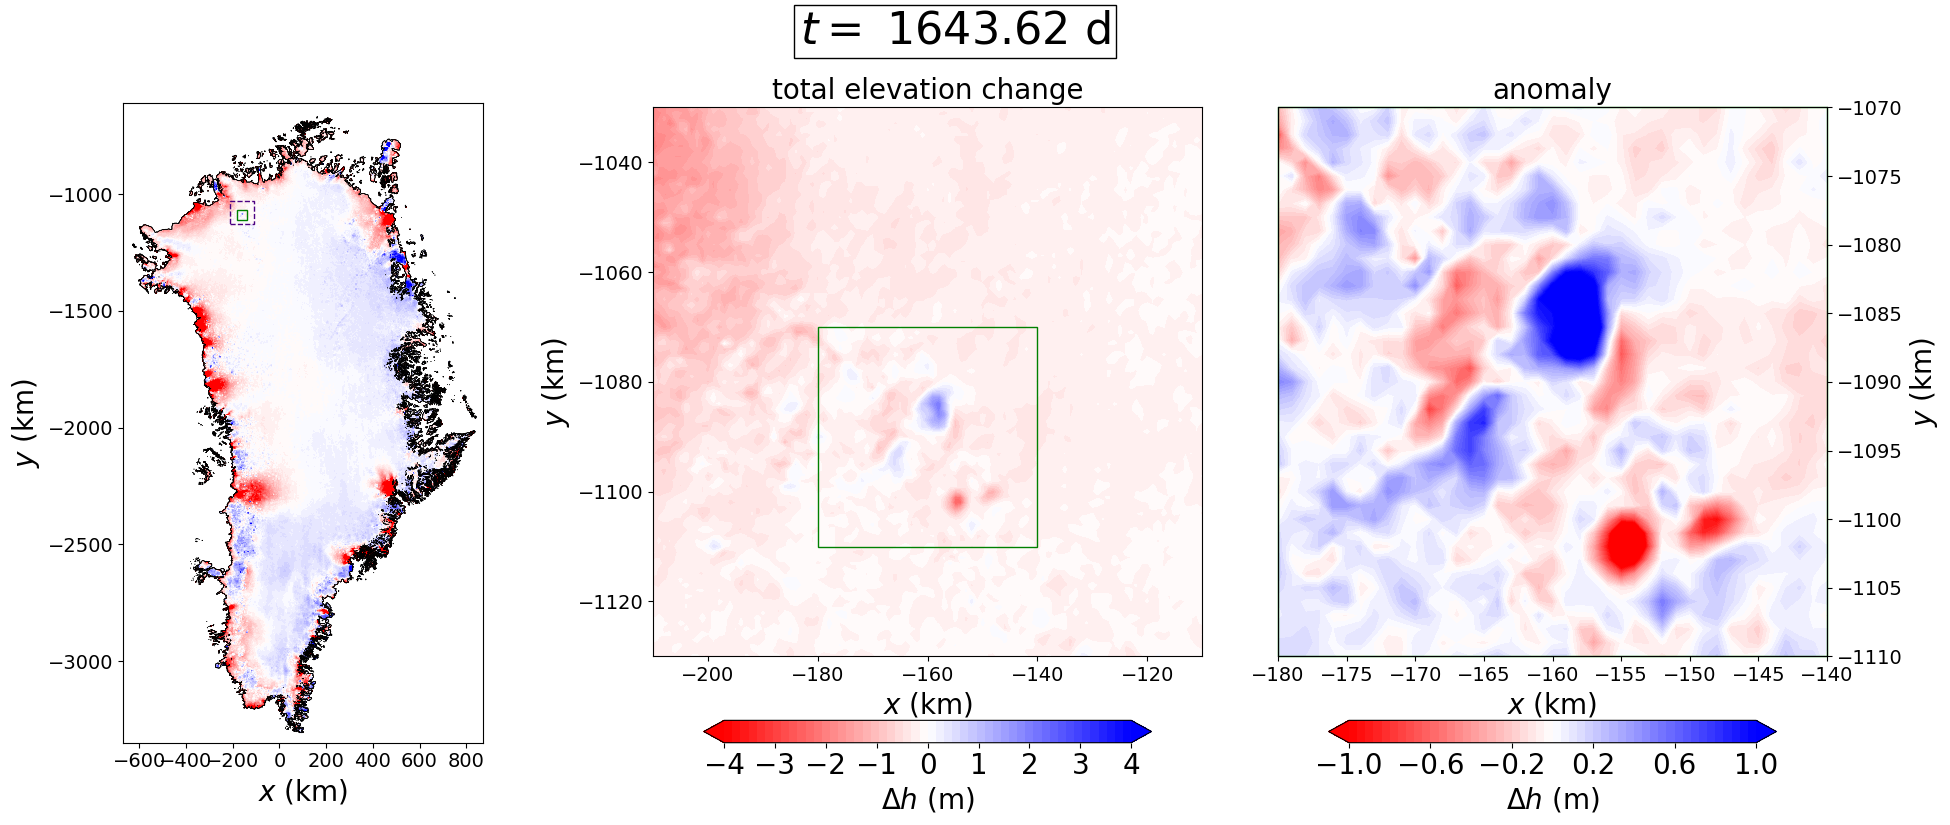

In [8]:
#--------------------------PLOTTING-------------------------------
%matplotlib inline
# plot png at each time step

plt.close()


# plot the data 

for i in [-1]: #range(np.size(t)):
    levels=np.linspace(-4,4,51)

    plt.figure(figsize=(20,8))
    plt.suptitle(r'$t=$ '+'{:.2f}'.format(t[i]-t[0])+' d',y=1.025,fontsize=32,bbox=dict(facecolor='none', edgecolor='black'))
    plt.subplot(131)
    p1 = plt.contourf(x/1000, y/1000,dh[i,:,:],cmap='bwr_r',levels=levels, extend='both')
    plt.contour(x/1e3, y/1e3, mask[i,:,:].filled(), colors='k', linewidths=0.25)
    plt.ylabel(r'$y$ (km)', fontsize=20)
    plt.xlabel(r'$x$ (km)', fontsize=20)
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14) 
    plt.gca().set_aspect('equal', 'box')
    rect = patches.Rectangle((x0/1e3-0.5*L0/1e3, y0/1e3-0.5*L0/1e3), L0/1e3, L0/1e3, linewidth=1, edgecolor='green', facecolor='none')
    plt.gca().add_patch(rect)
    rect0 = patches.Rectangle((x00/1e3-0.5*L00/1e3, y00/1e3-0.5*L00/1e3), L00/1e3, L00/1e3, linewidth=1, edgecolor='indigo',linestyle='--', facecolor='none')
    plt.gca().add_patch(rect0)
    
    plt.subplot(132)
    plt.title(r'total elevation change',fontsize=20)
    p = plt.contourf(X_sub0/1e3,Y_sub0/1e3,dh_sub0[i,:,:],levels=levels,cmap='bwr_r',extend='both')
    plt.xlabel(r'$x$ (km)',fontsize=20)
    plt.ylabel(r'$y$ (km)',fontsize=20)
    cbar = plt.colorbar(p, ticks=np.linspace(-4,4,9),orientation='horizontal', fraction=0.035, pad=0.1)
    cbar.ax.tick_params(labelsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cbar.set_label(r'$\Delta h$ (m)', fontsize=20)
    rect = patches.Rectangle((x0/1e3-0.5*L0/1e3, y0/1e3-0.5*L0/1e3), L0/1e3, L0/1e3, linewidth=1, edgecolor='green', facecolor='none',clip_on = False)
    plt.gca().add_patch(rect)
    plt.gca().set_aspect('equal', 'box')
  
    plt.subplot(133)
    plt.title(r'anomaly',fontsize=20)
    levels=np.linspace(-1,1,51)
    p = plt.contourf(X_sub/1e3,Y_sub/1e3,dh_loc[i,:,:],levels=levels,cmap='bwr_r',extend='both')
    plt.xlabel(r'$x$ (km)',fontsize=20)
    plt.ylabel(r'$y$ (km)',fontsize=20)
    cbar = plt.colorbar(p, ticks=np.linspace(-1,1,6),orientation='horizontal', fraction=0.035, pad=0.1)
    cbar.ax.tick_params(labelsize=20)   
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cbar.set_label(r'$\Delta h$ (m)', fontsize=20)
    rect = patches.Rectangle((x0/1e3-0.5*L0/1e3, y0/1e3-0.5*L0/1e3), L0/1e3, L0/1e3, linewidth=1, edgecolor='green', facecolor='none',clip_on = False)
    plt.gca().add_patch(rect)
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()
    plt.show()
    plt.close()


Next, we interpolate the data onto a fine space-time grid for use in the inversion. This can take a while depending on the size of the data.

In [9]:
def interp_tyx(f,t,y,x):
    Nx_f = 101            # fine Nx
    Ny_f = 101            # fine Ny
    Nt_f = 100            # fine Nt

    t0_f = np.linspace(t.min(),t.max(),num=Nt_f)  # fine time array
    x0_f = np.linspace(x.min(),x.max(),num=Nx_f)  # fine x coordinate array
    y0_f = np.linspace(y.min(),y.max(),num=Ny_f)  # fine y coordinate array
    t_f,y_f,x_f = np.meshgrid(t0_f,y0_f,x0_f,indexing='ij')

    points = (t_f,y_f,x_f)

    f_fine = griddata((t.ravel(),y.ravel(),x.ravel()),f.ravel(),points)

    return f_fine,t0_f,y0_f,x0_f



t_g,y_g,x_g = np.meshgrid(t,y_sub,x_sub,indexing='ij')

dh_f,t_f,y_f,x_f = interp_tyx(dh_sub,t_g,y_g,x_g)

t,y,x = np.meshgrid(t_f,y_f,x_f,indexing='ij')

Subtract off-lake component to compute elevation-change anomaly

In [10]:
dh_loc = localize(dh_f,x,y)  
off_lake = dh_f-dh_loc
off_lake = off_lake[:,0,0]

Plot elevation-change anomaly and off-lake elevation change component

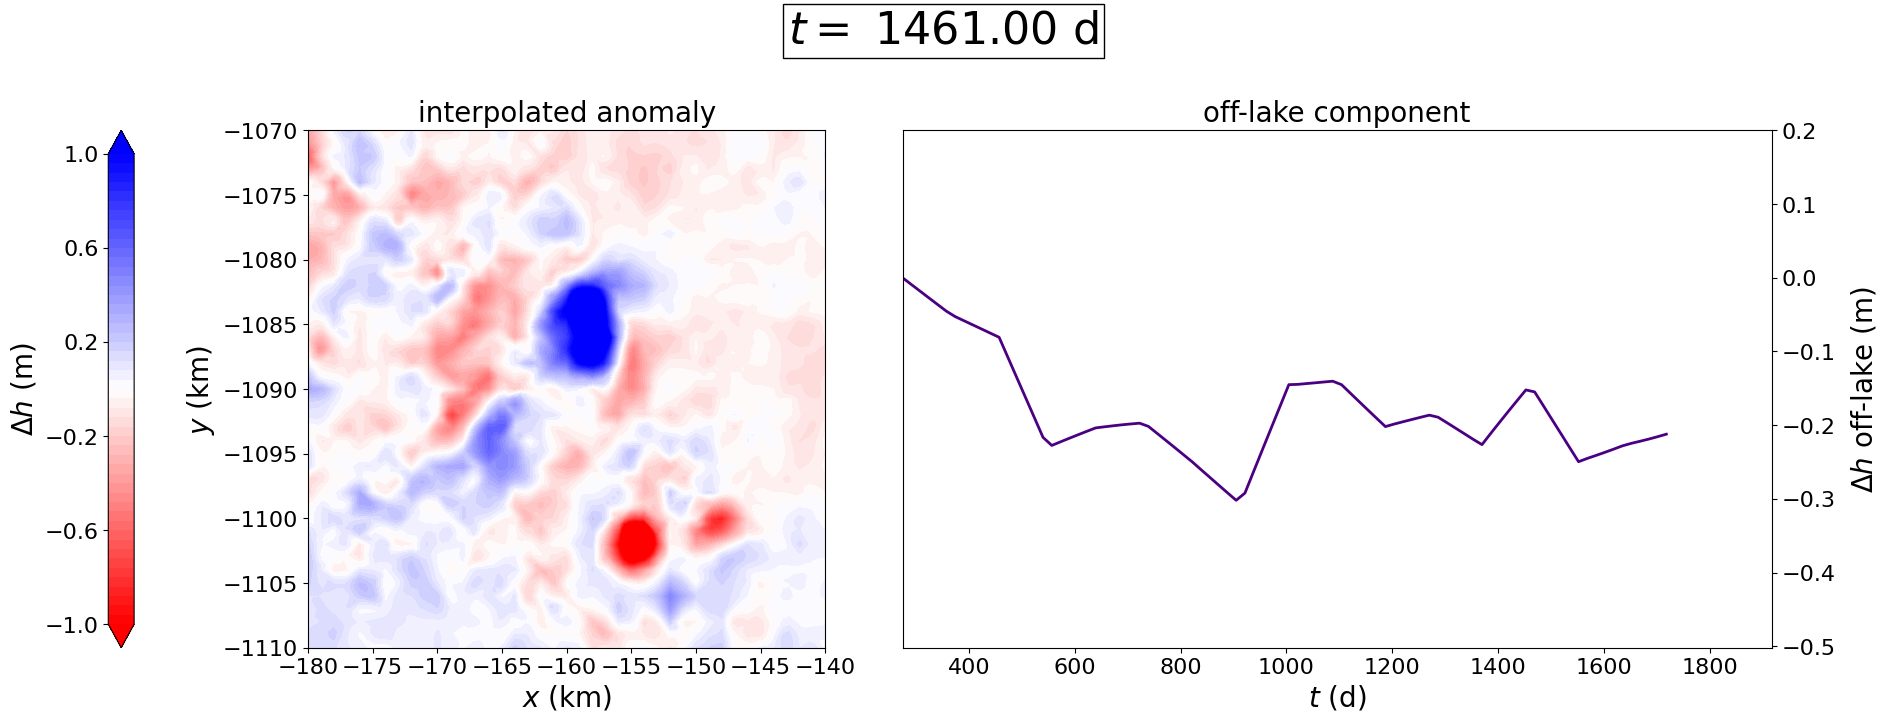

In [11]:
for i in [-12]:#np.arange(0,np.size(t_f),10):
    levels=np.linspace(-1,1,51)
    plt.figure(figsize=(19,7))
    plt.suptitle(r'$t=$ '+'{:.2f}'.format(t_f[i]-t_f[0])+' d',y=1.025,fontsize=32,bbox=dict(facecolor='none', edgecolor='black'))
    plt.subplot(121)
    plt.title(r'interpolated anomaly',fontsize=20)
    p = plt.contourf(x[i,:,:]/1e3,y[i,:,:]/1e3,dh_loc[i,:,:],levels=levels,cmap='bwr_r',extend='both')
    plt.xlabel(r'$x$ (km)',fontsize=20)
    plt.ylabel(r'$y$ (km)',fontsize=20)
    cbar = plt.colorbar(p, ticks=np.linspace(-1,1,6),orientation='vertical',location='left',fraction=0.035, pad=0.2)
    cbar.ax.tick_params(labelsize=16)   
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    cbar.set_label(r'$\Delta h$ (m)', fontsize=20)
    plt.gca().set_aspect('equal', 'box')
    plt.tight_layout()

    plt.subplot(122)
    plt.title(r'off-lake component',fontsize=20)
    plt.plot(t_f[0:i],off_lake[0:i],color='indigo',linewidth=2)
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    plt.xlabel(r'$t$ (d)',fontsize=20)
    plt.ylabel(r'$\Delta h$ off-lake (m)',fontsize=20,labelpad=10)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(off_lake.min()-0.2,off_lake.max()+0.2)
    plt.xlim(t_f.min(),t_f.max())
    plt.tight_layout()
    plt.show()
    plt.close()

Get average BedMachine thickness for the boxed area

In [12]:
#----------------------------- Bedmachine thickness ----------------------------
fn = paths['bedmachine']
ds = nc.Dataset(fn)
x = ds['x'][:]                                   # m
y = ds['y'][:]                                   # m
H = ds['thickness'][:]                           # ice thickness (m)

ind_x = np.arange(0,np.size(x),1)
ind_y = np.arange(0,np.size(y),1)

x_sub = x[(x>=x_min)&(x<=x_max)]
y_sub = y[(y>=y_min)&(y<=y_max)]

inds_x = ind_x[(x>=x_min)&(x<=x_max)]
inds_y = ind_y[(y>=y_min)&(y<=y_max)]

inds_xy = np.ix_(inds_y,inds_x)

H_mean = np.mean(H[inds_xy])

In [13]:
# print ice thickness
print(str(H_mean)+" m")

1553.6754 m


Get average surface velocity:

In [14]:
#------------------------ surface velocity -------------------------------------
fn_u = paths['measures_x']
fn_v = paths['measures_y']
ds_u = rio.open(fn_u)
ds_v = rio.open(fn_v)

with rio.open(fn_u) as src:
    band1 = src.read(1)
    height = band1.shape[0]
    width = band1.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)

u = ds_u.read(1)
v = ds_v.read(1)    
speed = np.sqrt(u**2 + v**2)
x = np.array(xs)
y = np.array(ys) 

X = x[0,:]
Y = y[:,0]

ind_x = np.arange(0,np.size(X),1)
ind_y = np.arange(0,np.size(Y),1)

x_sub = X[(X>=x_min)&(X<=x_max)]
y_sub = Y[(Y>=y_min)&(Y<=y_max)]

inds_x = ind_x[(X>=x_min)&(X<=x_max)]
inds_y = ind_y[(Y>=y_min)&(Y<=y_max)]

inds_xy = np.ix_(inds_y,inds_x)

u0 = u[inds_xy]
v0 = v[inds_xy]

u_mean = np.mean(u0)
v_mean = np.mean(v0)

Plot the surface velocity: 

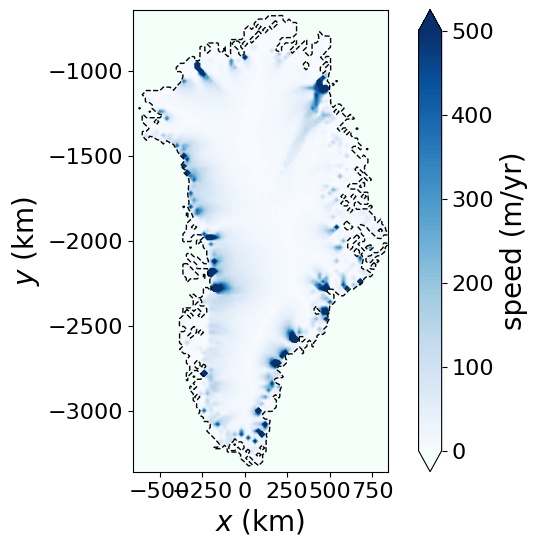

In [15]:
cmap = plt.cm.Blues
cmap.set_under('mintcream')
ticks = np.linspace(0,5e2,6)
speed[speed>1e7] = -100 # modify ocean color

plt.figure(figsize=(8,6))
p = plt.contourf(x[::100,::100]/1e3,y[::100,::100]/1e3,speed[::100,::100],cmap=cmap,levels=np.linspace(0,5e2,100),vmin=1,vmax=5e2,extend='both')
cbar = plt.colorbar(ticks=ticks)
plt.contour(x[::100,::100]/1e3,y[::100,::100]/1e3,speed[::100,::100],levels=[-20],colors='k',linewidths=1)
plt.xlabel(r'$x$ (km)',fontsize=20)
plt.ylabel(r'$y$ (km)',fontsize=20)
cbar.ax.tick_params(labelsize=16)   
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar.set_label(r'speed (m/yr)', fontsize=20)
plt.gca().set_aspect('equal', 'box')
plt.show()
plt.close()

Set viscosity and basal drag estimates (figure out how to get from ISSM later):

In [16]:
eta_mean = 1e14
beta_mean = 1e10

Save the data and model parameters as arrays

In [17]:
# ----------------------------- SAVE DATA --------------------------------------
np.save('../'+data_name+'/eta.npy',np.array([eta_mean]))    # viscosity: Pa s
np.save('../'+data_name+'/beta.npy',np.array([beta_mean]))  # basal drag: Pa s / m
np.save('../'+data_name+'/H.npy',np.array([H_mean]))        # thickness: m
np.save('../'+data_name+'/h_obs.npy',dh_loc)                # elevation anomaly: m
np.save('../'+data_name+'/off_lake.npy',off_lake)           # off-lake timeseries: m
np.save('../'+data_name+'/t.npy',(t_f-t_f[0])/365.0)        # time: yr
np.save('../'+data_name+'/u.npy',np.array([u_mean]))        # vel x: m/yr
np.save('../'+data_name+'/v.npy',np.array([v_mean]))        # vel y: m/yr

np.save('../'+data_name+'/x.npy',(x_f-x_f.mean())/H_mean)   # x coord (scaled)
np.save('../'+data_name+'/y.npy',(y_f-y_f.mean())/H_mean)   # y coord (scaled)

np.save('../'+data_name+'/x_d.npy',x_f/1e3)     # x coord. for plotting results
np.save('../'+data_name+'/y_d.npy',y_f/1e3)     # y coord. for plotting results

In [18]:
# example script that runs the inversion
from inversion import invert
import numpy as np
from params import data_dir
from print_params import print_params

In [19]:
# print the auxiliary model parameters
print_params()

lake name: north


auxiliary model parameters:
H = 1.5536754150390626 km
beta = 1.00e+10 Pa s m^-1
eta = 1.00e+14 Pa s
u = -47.458923 m yr^-1
v = 47.25625 m yr^-1
relaxation time = 0.4537009305287881 yr


In [20]:
# load elevation data (h_obs)
h_obs = np.load(data_dir+'/h_obs.npy')
x_d = np.load(data_dir+'/x_d.npy')
y_d = np.load(data_dir+'/y_d.npy')

# set regularization parameter
eps = 1e0

# set reference time to define elevation anomaly
t_ref = 0.0 

In [21]:
# solve for the basal vertical velocity inversion
w_inv,h_fwd,mis = invert(h_obs,eps=eps,t_ref=t_ref)

Solving normal equations with CG....

CG iter. 570: rel. residual norm = 1.26e-06,  tol = 1.00e-06 
...CG converged!



Next we will define the lake boundary with matplotlib and shapely

In [28]:
# define list for storing lake boundary geometry 
poly_list = []
outlines = gpd.GeoSeries(poly_list)

Run the following code snippet as many times as you want to select subglacial lake boundaries. (Press enter after selecting all of the points that define the boundary.)

In [31]:
%matplotlib tk

# pick a timestep to define lake boundary

i = -12
fig = plt.figure(figsize=(8,6))
levels= np.floor(np.max(np.abs(w_inv)))*np.linspace(-1,1,51)

plt.title(r'choose lake boundary!',fontsize=20)
p = plt.contourf(x_d,y_d,w_inv[i,:,:],levels=levels,cmap='bwr_r',extend='both')
if outlines.size>0:
    outlines.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=3)
plt.xlabel(r'$x$ (km)',fontsize=20)
plt.ylabel(r'$y$ (km)',fontsize=20)
cbar = plt.colorbar(p,orientation='horizontal', fraction=0.035, pad=0.15)
cbar.ax.tick_params(labelsize=14)   
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar.set_label(r'$\Delta h$ (m)', fontsize=20)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
pts = plt.ginput(-1,timeout=-1)
poly_list.append(Polygon(pts))
outlines = gpd.GeoSeries(poly_list)
outlines.plot(edgecolor='k',facecolor='none',ax=plt.gca(),linewidth=3)
plt.pause(2)
plt.close()

In [32]:
from plot_results import plot

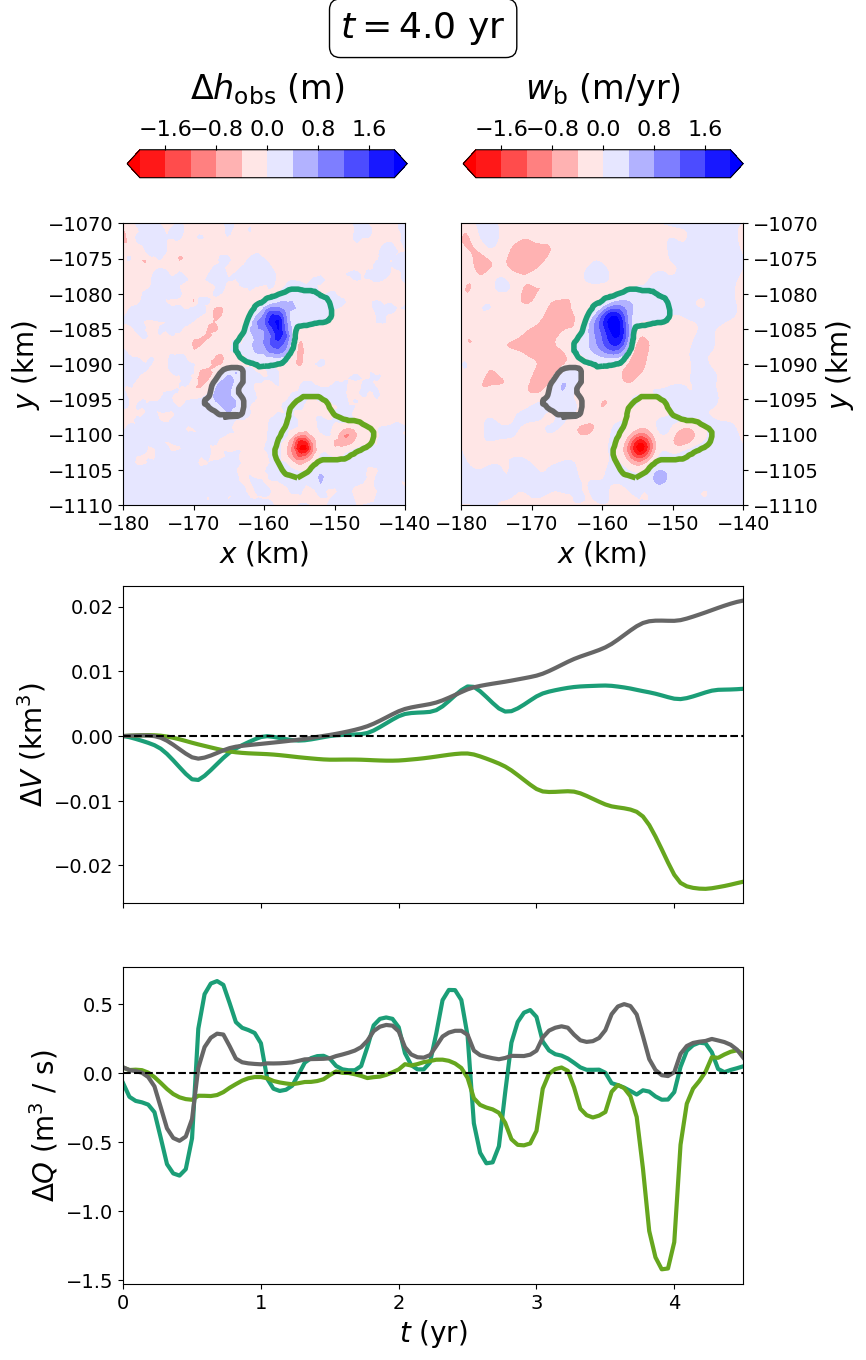

In [33]:
%matplotlib inline
# set the contour plot limits for the elevation and inversion with h_lim and w_lim, resp.
timesteps = [-12]        # set timesteps to list with length == 1 to print single snapshot
plot(outlines,t_ref,timesteps)  